## This Notebook will aim to Optimize linear Models

I have a lot of different automatic results in the previous notebook so just manually take most optimal features and reduce from there



## Start with Naive Bayes


'avg3Months_Loan', 'avg3Months_DebtCollection', 'avg6Months_Loan', 'avg6Months_Gambling', 'avg_Gambling', 'avg_Salary', 'avg3Months_Deposit', 'avg3Months_Gambling','avg_Loan', 'avg_HousingCost', 'avg3Months_CashWithdrawal' ,'avg6Months_DirectDebit', 'avg_Gaming', 'avg3Months_Gaming', 'avg_CashWithdrawal', 'avg_OtherIncome', 'avg6Months_CashWithdrawal', 'avg6Months_InstallmentPayment', 'avg_DirectDebit', 'avg6Months_HousingCost', 'avg6Months_Gaming', 'avg3Months_DirectDebit'
'count_Loan', 'trend_DebtCollection', 'sum_Loan', 'trend_Deposit', 'sum_Gambling', 'count_Gambling', 'sum_Salary', 'trend_CashWithdrawal', 'sum_DirectDebit',

'sum installmentPayments', 'trend_Loan', 'Gambling_sum9Months', 'MoneyRemittance_monthlyAvg','trend_Salary', 'MoneyRemittance_partOfSalary9Months', 'Gambling_sum12Months', 'trend_MoneyRemittance', 'Crypto_count3Months', 'trend_OtherIncome', 'trend_PassiveIncome', 'Gambling_count9Months', 'Gambling_partOfSalary3Months', 'MoneyRemittance_category',

'DebtCollection_count9Months', 'CashWithdrawal_sum3Months'

'DebtCollection_sum3Months', 'DebtCollection_sum9Months', 'InstallmentPayment_count12Months', 'DebtCollection_partOfSalary12Months', 'DebtCollection_sum12Months', 'InstallmentPayment_count9Months',



In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')


df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge'])

base = df.drop(columns=['HasCoapp'])




Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.5576
Test Gini: 0.2924


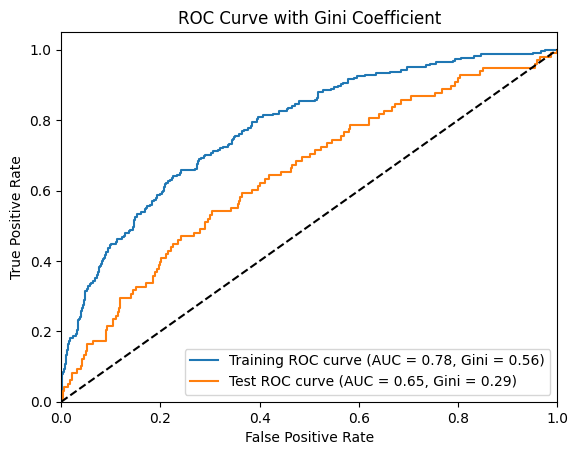

In [2]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Custom classifier wrapper for sklearn
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.005, dropout_rate=0.5, num_epochs=100):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = None
    
    def _initialize_model(self):
        model = RegularizedClassifier(self.input_dim, self.dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return model, optimizer
    
    def fit(self, X, y):
        train_dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.model, optimizer = self._initialize_model()
        criterion = nn.BCELoss()
        
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(train_loader.dataset)
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X).float())
        return outputs.numpy().flatten()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

class RegularizedClassifier(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(RegularizedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 28)
        self.bn2 = nn.BatchNorm1d(28)
        self.fc3 = nn.Linear(28, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(base)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


## USE RF REDUCED SET

In [3]:
sortedbest_features_from_rf = [
    'HousingCost_sum3Months', 'Crypto_count3Months', 'avg_DebtCollection',
    'CashWithdrawal_count6Months', 'count_Gaming', 'MobilePayment_sum12Months',
    'Gaming_sum12Months', 'HousingCost_count3Months',
    'Gaming_partOfSalary3Months', 'Crypto_count12Months', 'avg3Months_Gambling',
    'trend_Loan', 'avg3Months_DirectDebit', 'Crypto_count6Months',
    'InstallmentPayment_count6Months', 'avg3Months_OtherIncome',
    'Gaming_category', 'CashWithdrawal_monthlyAvg', 'count_Gambling',
    'DirectDebit_sum3Months', 'avg3Months_Gaming', 'MobilePayment_sum9Months',
    'DebtCollection_sum6Months', 'Gaming_sum9Months', 'Gaming_monthlyAvg',
    'Gaming_count6Months', 'sum_Gaming', 'Unclassified_count6Months',
    'DebtCollection_partOfSalary6Months', 'MobilePayment_partOfSalary3Months',
    'CashWithdrawal_partOfSalary12Months', 'sum_Deposit',
    'DirectDebit_sum12Months', 'Gambling_partOfSalary6Months',
    'MobilePayment_monthlyAvg', 'sum_DebtCollection',
    'HousingCost_partOfSalary6Months', 'Gambling_count6Months',
    'avg6Months_DirectDebit', 'avg6Months_HousingCost', 'sum_HousingCost',
    'MobilePayment_sum6Months', 'avg_OtherIncome', 'CashWithdrawal_sum6Months',
    'CashWithdrawal_partOfSalary6Months', 'DirectDebit_count12Months',
    'avg_Deposit', 'avg_HousingCost', 'DebtCollection_count6Months',
    'MobilePayment_partOfSalary6Months',
    'HousingCost_count6Months', 'Gaming_count12Months', 'trend_Deposit',
    'MobilePayment_partOfSalary12Months', 'Gambling_partOfSalary3Months',
    'Gambling_partOfSalary9Months', 'sum_OtherIncome', 'count_CashWithdrawal',
    'trend_Gambling', 'count_HousingCost', 'DirectDebit_sum9Months',
    'Gaming_partOfSalary12Months', 'avg6Months_Gaming',
    'avg6Months_MobilePayment', 'InstallmentPayment_partOfSalary12Months',
    'trend_Salary', 'avg6Months_Gambling', 'InstallmentPayment_monthlyAvg',
    'avg3Months_MobilePayment', 'DebtCollection_count9Months',
    'avg6Months_Deposit', 'InstallmentPayment_category', 'Gambling_sum6Months',
    'avg3Months_Salary', 'avg6Months_CashWithdrawal',
    'DebtCollection_partOfSalary9Months', 'MobilePayment_count12Months',
    'avg_Gambling', 'avg6Months_DebtCollection',
    'InstallmentPayment_sum6Months', 'count_Salary', 'avg_Gaming',
    'Unclassified_partOfSalary6Months', 'HousingCost_sum6Months',
    'DebtCollection_category', 'HousingCost_count12Months',
    'avg6Months_InstallmentPayment', 'Gambling_monthlyAvg',
    'count_InstallmentPayment', 'sum_Gambling', 
    'Gaming_count3Months', 'Gambling_category',
    'InstallmentPayment_sum12Months', 'CashWithdrawal_sum12Months',
    'CashWithdrawal_sum3Months', 'avg3Months_Deposit',
    'trend_InstallmentPayment', 'sum_DirectDebit',
    'InstallmentPayment_sum9Months', 'DebtCollection_partOfSalary12Months',
    'MobilePayment_sum3Months', 'Unclassified_monthlyAvg',
    'InstallmentPayment_count12Months', 'HousingCost_category',
    'avg3Months_InstallmentPayment', 'Unclassified_partOfSalary3Months',
    'DebtCollection_monthlyAvg', 'Gambling_sum12Months', 'count_MobilePayment',
    'Unclassified_partOfSalary9Months', 'trend_Gaming',
    'InstallmentPayment_partOfSalary9Months',
    'InstallmentPayment_partOfSalary3Months',
    'CashWithdrawal_partOfSalary9Months', 'Unclassified_sum9Months',
    'avg_InstallmentPayment', 'InstallmentPayment_sum3Months',
    'Unclassified_sum6Months',  'Gambling_sum9Months',
    'sum_InstallmentPayment', 'InstallmentPayment_partOfSalary6Months',
    'avg3Months_CashWithdrawal', 'trend_MobilePayment',
    'DebtCollection_sum9Months', 'Unclassified_count12Months',
    'avg6Months_Salary', 'avg_Loan', 'DebtCollection_sum12Months', 'sum_Loan',
    'CashWithdrawal_partOfSalary3Months', 'Unclassified_partOfSalary12Months',
    'trend_DebtCollection', 'sum_Salary', 'avg_Salary',
    'Unclassified_sum3Months', 'avg3Months_DebtCollection',
    'DebtCollection_sum3Months', 'avg6Months_Loan', 'count_Loan',
    'Unclassified_sum12Months', 'avg3Months_Loan'
]

forforsta = base[['Ever90'] + list(sortedbest_features_from_rf)]


In [4]:
base

,Ever90,avg_CashWithdrawal,avg_Crypto,avg_DebtCollection,avg_Deposit,avg_DirectDebit,avg_Gambling,avg_Gaming,avg_HousingCost,avg_InstallmentPayment,...,Unclassified_partOfSalary6Months,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors
0,1,0,0,1017,1243,0,11,21,887,8444,...,770.0,50227.0,224.1,248.5,247.0,258.4,630444,81995,288551,519248
1,1,1717,0,899,3788,0,99403,1615,0,14614,...,1330.7,763.7,1333.3,1553.4,2678645.0,241491.0,1655157,2249127,0,0
2,1,7757,0,1614,18338,0,845,0,0,8678,...,841.0,85589.0,322.8,415.5,320.5,331.8,882268,279047,442904,685525
3,1,2885,0,956,1502,0,896,38,644,14717,...,446.6,268.0,476.0,439.5,883993.0,100348.0,452428,627919,0,0
4,1,2,0,2337,1063,0,1701,43,3178,9537,...,318.5,379.3,1362741.0,251386.0,547363.0,971946.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0,1297,0,2293,3276,0,0,19,2284,5349,...,241.9,195.3,381102.0,84024.0,274075.0,312523.0,0,0,0,0
3489,0,1142,0,14629,1435,0,0,29,1750,5358,...,155.3,121.2,348937.0,91087.0,215240.0,265065.0,0,0,0,0
3490,0,25,0,3304,1649,0,0,44,0,8888,...,640.0,40754.0,165.3,135.9,130.5,145.1,509094,147353,245526,367844
3491,0,0,0,0,986,742,261,33,0,22999,...,505.0,38839.0,96.0,76.7,72.3,92.7,487593,113811,198074,353883


In [5]:
forforsta

,Ever90,HousingCost_sum3Months,Crypto_count3Months,avg_DebtCollection,CashWithdrawal_count6Months,count_Gaming,MobilePayment_sum12Months,Gaming_sum12Months,HousingCost_count3Months,Gaming_partOfSalary3Months,...,trend_DebtCollection,sum_Salary,avg_Salary,Unclassified_sum3Months,avg3Months_DebtCollection,DebtCollection_sum3Months,avg6Months_Loan,count_Loan,Unclassified_sum12Months,avg3Months_Loan
0,1,22.9,0,1017,0,4,6.7,0.1,59221,1.0,...,86.0,281381,23448,248.5,957,8.7,3033,9,224.1,2733
1,1,0.0,0,899,20,24,319.4,0.2,0,1615.0,...,-13.4,201297,20129,1553.4,1666,7.4,11083,24,1333.3,0
2,1,0.0,4098,1614,0,0,60.0,0.0,39955,0.0,...,52.0,272161,22680,415.5,861,3.8,2852,35,322.8,2212
3,1,6.3,0,956,31,6,59.8,0.6,0,38.0,...,49.2,214204,17850,439.5,1515,6.6,3048,25,476.0,266
4,1,7942.0,0,2337,0,2,101328.0,0.0,1,0.0,...,73.3,363693,27976,251386.0,2214,6644.0,0,24,1362741.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0,19518.0,0,2293,12,6,84374.0,277.0,3,0.3,...,-100.0,135672,11306,84024.0,0,0.0,298,5,381102.0,0
3489,0,0.0,0,14629,6,4,34415.0,415.0,0,0.0,...,-79.7,288782,22214,91087.0,6844,20532.0,423,2,348937.0,0
3490,0,0.0,0,3304,0,8,16.2,0.1,54619,5.0,...,51.6,307965,25663,135.9,4771,13.2,276,4,165.3,0
3491,0,0.0,2460,0,0,2,12.2,0.1,146780,1.0,...,0.0,505149,42095,76.7,0,0.0,0,0,96.0,0


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4114
Test Gini: 0.3106


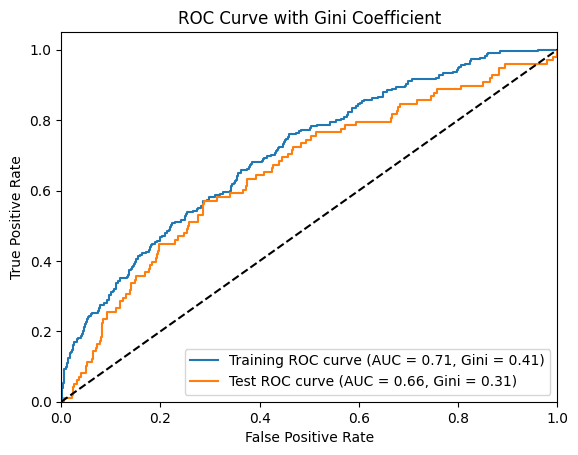

In [6]:

# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4038
Test Gini: 0.3398


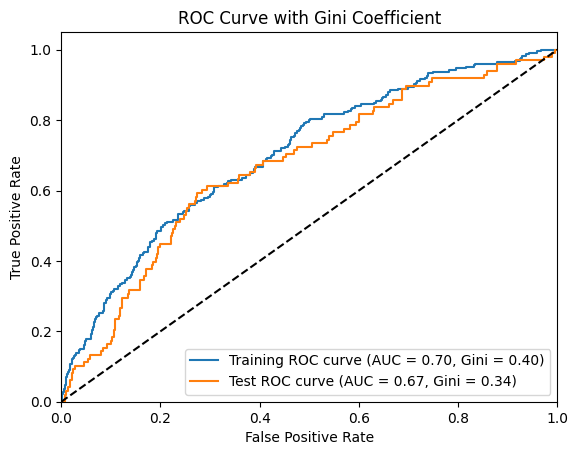

In [12]:
forforsta = base[['Ever90']+list(sortedbest_features_from_rf[60:])]




# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4106
Test Gini: 0.3557


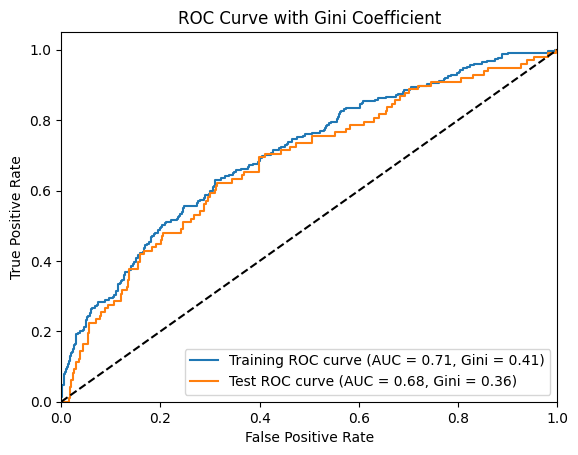

In [8]:
forforsta = base[['Ever90']+list(sortedbest_features_from_rf[75:])]




# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4162
Test Gini: 0.3281


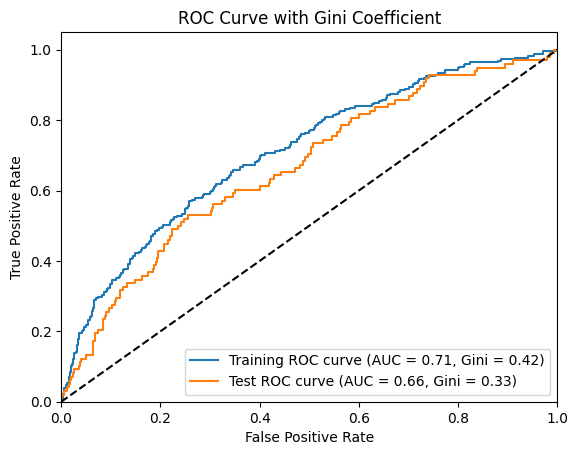

In [9]:
forforsta = base[['Ever90']+list(sortedbest_features_from_rf[90:])]




# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.3800
Test Gini: 0.3330


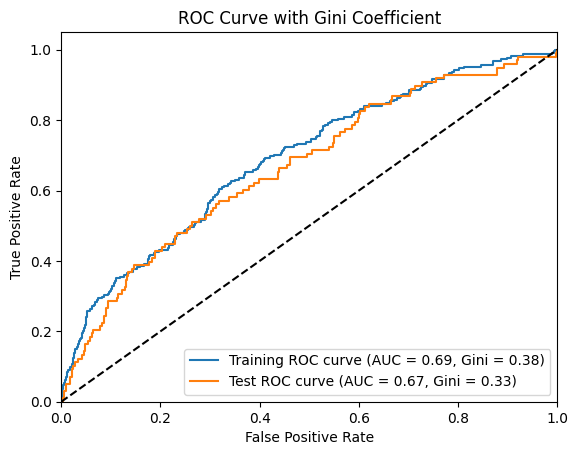

In [10]:
forforsta = base[['Ever90']+list(sortedbest_features_from_rf[100:])]




# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Binary Split: Ever90
0    3170
1     323
Name: count, dtype: int64
Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.3813
Test Gini: 0.3374


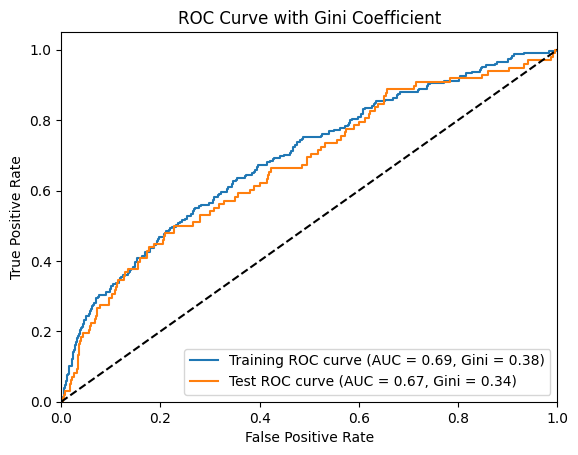

In [11]:
forforsta = base[['Ever90']+list(sortedbest_features_from_rf[83:])]




# Assuming DataPreprocessor is predefined
preprocessor = DataPreprocessor(forforsta)
(Xtrain, Ytrain), (Xtest, Ytest), train_upsampled = preprocessor.get_split_data_with_upsample_and_scaling(0.7, upsample=False)

input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")
